# IMPORT LIBRARIES

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from tkinter import Tk, filedialog, simpledialog, messagebox
import statsmodels.api as sm


# EXTRACT DATA AND PERFORM TEST


Summary Statistics:
+----------+---------------+---------+---------+-----------+------------+---------+---------+
| Groups   |   Sample Size |     Sum |    Mean |   Std Dev |   Variance |     LCI |     UCI |
+==========+===============+=========+=========+===========+============+=========+=========+
| X        |          1000 | 49924.8 | 49.9248 |   9.75964 |    95.2506 | 49.3199 | 50.5297 |
+----------+---------------+---------+---------+-----------+------------+---------+---------+
| Y        |          1000 | 50326.2 | 50.3262 |   9.9888  |    99.7761 | 49.7071 | 50.9453 |
+----------+---------------+---------+---------+-----------+------------+---------+---------+
| Z        |          1000 | 50508   | 50.508  |  10.0402  |   100.806  | 49.8857 | 51.1303 |
+----------+---------------+---------+---------+-----------+------------+---------+---------+


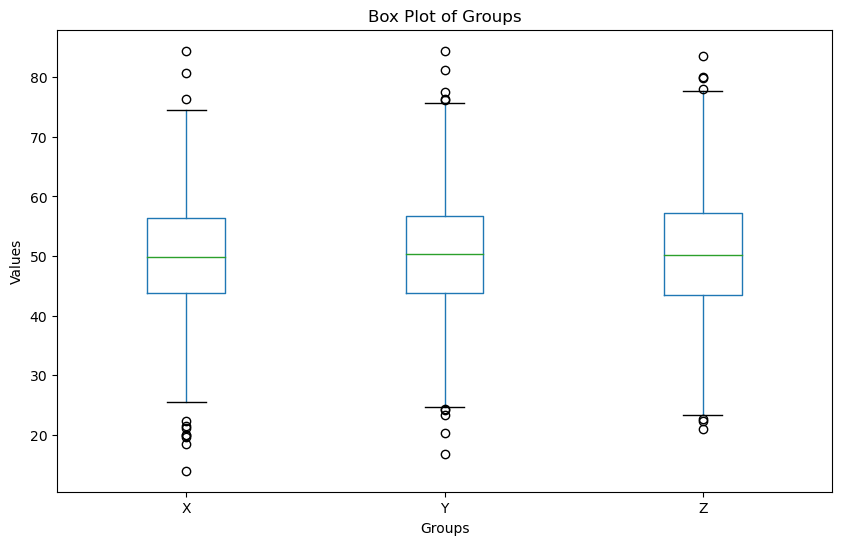

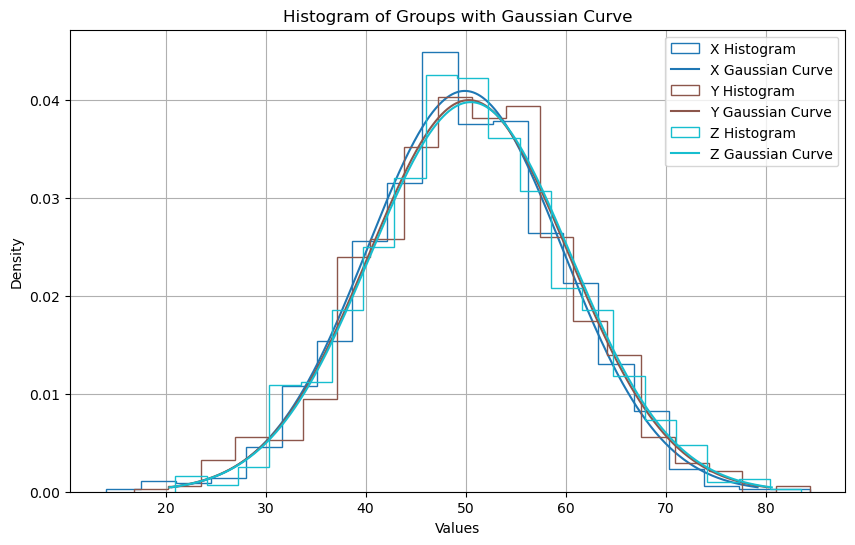


ANOVA Results:
                 sum_sq      df         F    PR(>F)
C(group)     178.127385     2.0  0.903182  0.405388
Residual  295537.079071  2997.0       NaN       NaN

Fail to reject the null hypothesis: There is no significant difference between groups.


In [10]:
def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        df = pd.read_excel(file_path)  # Read Excel file into a temporary DataFrame
        df = df.dropna(axis=1, how='all')  # Drop columns that are entirely blank
        return df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")  # Print error message if file reading fails
        return None  # Return None if an error occurs

def calculate_summary_stats(df, group_cols):
    """Calculate summary statistics for each group."""
    summary_data = []
    for col in group_cols:
        group_data = df[col]
        sample_size = len(group_data)
        group_sum = group_data.sum()
        group_mean = group_data.mean()
        group_std = group_data.std()
        group_var = group_data.var()
        
        # Calculate confidence intervals
        z_critical = stats.norm.ppf(0.975)  # for 95% confidence interval
        group_se = group_std / np.sqrt(sample_size)
        lci = group_mean - z_critical * group_se
        uci = group_mean + z_critical * group_se
        
        summary_data.append([col, sample_size, group_sum, group_mean, group_std, group_var, lci, uci])
    return summary_data


def perform_one_way_anova(df, group_cols):
    """Performs one-way ANOVA and displays summary statistics, box plot, histogram, and ANOVA results."""
    try:
        # Prepare data for ANOVA
        data = [df[col] for col in group_cols]

        # Summary Statistics
        summary_data = calculate_summary_stats(df, group_cols)
        
        # Print Summary Statistics Table
        print("\nSummary Statistics:")
        print(tabulate(summary_data, headers=["Groups", "Sample Size", "Sum", "Mean", "Std Dev", "Variance", "LCI", "UCI"], tablefmt="grid"))

        # Plot Box Plot
        plot_boxplot(df, group_cols)

        # Plot Histogram
        plot_histogram(df, group_cols)

        # Perform one-way ANOVA using OLS model
        df_anova = pd.DataFrame({'data': np.concatenate(data),
                                 'group': np.repeat(group_cols, [len(df[col]) for col in group_cols])})
        model = sm.formula.ols('data ~ C(group)', data=df_anova).fit()

        # Generate ANOVA Table
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Print ANOVA Table
        print("\nANOVA Results:")
        print(anova_table)

        # Interpret the results
        alpha = 0.05  # significance level
        p_value = anova_table['PR(>F)']['C(group)']
        if p_value < alpha:
            print("\nReject the null hypothesis: There is a significant difference between at least two groups.")
        else:
            print("\nFail to reject the null hypothesis: There is no significant difference between groups.")

    except Exception as e:
        print(f"Error performing one-way ANOVA: {e}")

def plot_boxplot(df, group_cols):
    """Plot box plots for each group."""
    plt.figure(figsize=(10, 6))
    df.boxplot(column=group_cols)
    plt.title('Box Plot of Groups')
    plt.xlabel('Groups')
    plt.ylabel('Values')
    plt.grid(False)
    plt.show()

def plot_histogram(df, group_cols):
    """Plot histograms for each group with Gaussian curve."""
    plt.figure(figsize=(10, 6))
    colors = plt.cm.get_cmap('tab10', len(group_cols))  # Get a colormap with the desired number of colors

    for idx, col in enumerate(group_cols):
        # Plot histogram
        hist_color = colors(idx)
        plt.hist(df[col], bins=20, density=True, histtype='step', label=f'{col} Histogram', color=hist_color)

        # Plot Gaussian curve with matching color
        mean = df[col].mean()
        std_dev = df[col].std()
        x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 1000)
        y = norm.pdf(x, mean, std_dev)
        plt.plot(x, y, label=f'{col} Gaussian Curve', color=hist_color)

    plt.title('Histogram of Groups with Gaussian Curve')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


def get_user_column_selection(df):
    """Gets user input for selecting columns using dialog boxes."""
    root = Tk()
    root.withdraw()  # Hide the main window

    # Get column names from the DataFrame
    columns = df.columns.tolist()

    while True:
        num_groups = simpledialog.askinteger("Input", "Enter the number of groups (must be 3 or more):")
        if num_groups is None:
            return None, None  # User canceled the input
        elif num_groups >= 3:
            break
        else:
            messagebox.showerror("Error", "Please enter 3 or more groups.")

    group_cols = []
    for i in range(num_groups):
        group_col = simpledialog.askstring("Input", f"Enter the column name for group {i + 1}:\nAvailable columns: {', '.join(columns)}")
        if group_col is None:
            return None, None  # User canceled the input
        group_cols.append(group_col)

    return group_cols

def main():
    # Open a file dialog to select Excel file
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    if not file_path:
        print("No file selected.")
        return

    # Read Excel file into DataFrame
    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    # Get user input for selecting columns
    group_cols = get_user_column_selection(df)
    if group_cols is None:
        print("Error: User canceled the input or entered invalid data.")
        return

    # Perform one-way ANOVA, display tables, and plot box plot
    perform_one_way_anova(df, group_cols)

if __name__ == "__main__":
    main()
